In [ ]:
import pathlib as pl

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

# Download latest version
tmdb_path = next(pl.Path(kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")).glob("*.csv"))
print(tmdb_path)
(mvls_links_path, mvls_genometags_path, mvls_movies_path, mvls_genomescores_path, mvls_tags_path, mvls_ratings_path) = (
  list(pl.Path(kagglehub.dataset_download("grouplens/movielens-20m-dataset")).iterdir())
)
print(
  mvls_links_path, mvls_genometags_path, mvls_movies_path, mvls_genomescores_path, mvls_tags_path, mvls_ratings_path
)


def compress(df_: pd.DataFrame) -> pd.DataFrame | None:
  """
  Automatically downcast numeric dtypes to the minimal possible.

  Will not modify other dtypes (e.g., datetime, str, object, etc.).

  Parameters
  ----------
  df_ : pd.DataFrame
      The dataframe to be downcasted.

  Returns
  -------
  pd.DataFrame or None
      Returns the downcasted dataframe if `inplace=False`, otherwise returns `None`.
  """
  for col in df_.select_dtypes(include=["number"]).columns:
    df_[col] = (
      pd.to_numeric(df_[col], downcast="integer")
      if pd.api.types.is_integer_dtype(df_[col])
      else pd.to_numeric(df_[col], downcast="float")
    )
  return df_


def solve_sparse_feature(
  df_to_count: pd.DataFrame, id_col: str, feat_col: str, concentration: float = 0.9
) -> pd.DataFrame:
  """
  Solve sparse features by grouping less frequent categories into 'other'.

  Parameters
  ----------
  df_to_count : pd.DataFrame
      The dataframe containing the features to process.
  id_col : str
      The column name representing the unique identifier (e.g., userId).
  feat_col : str
      The column name representing the feature to process (e.g., original_language).
  concentration : float, optional
      The cumulative concentration threshold for grouping less frequent categories, by default 0.9.

  Returns
  -------
  pd.DataFrame
      A dataframe with one-hot encoded columns for the grouped features.
  """
  _fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  feat_count = df_to_count[feat_col].value_counts(normalize=True).sort_values(ascending=False)
  feat_count.plot.pie(autopct="%1.1f%%", ax=axes[0])
  # Step 1: Identify the top 10 languages globally
  feat_cumsum = feat_count.cumsum()
  feat_mask = feat_cumsum <= concentration
  feats_to_keep = feat_mask.index[feat_mask]

  # Step 2: Filter to include only top languages, mark others as "Other"
  df_to_count["grouped_feature"] = df_to_count[feat_col].apply(lambda x: x if x in feats_to_keep else "other")

  # Step 3: Count occurrences of each language per user
  counts = df_to_count.groupby([id_col, "grouped_feature"]).size().reset_index(name="count")

  # Step 4: Pivot the data to get one column per language (including "Other")
  final_features = compress(counts.pivot_table(index=id_col, columns="grouped_feature", values="count", fill_value=0))

  final_features = final_features.rename(columns={c: f"{feat_col}_count_{c}" for c in final_features.columns})
  ((final_features != 0).sum() / (final_features != 0).sum().sum()).sort_values(ascending=False).cumsum().plot.bar(
    ax=axes[1]
  )
  plt.tight_layout()
  plt.show()
  return final_features


features_to_normalize = []

/home/dodo/code/recsys-movies/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/dodo/.cache/kagglehub/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/versions/431/TMDB_movie_dataset_v11.csv
/home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv /home/dodo/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv


## Generating movie features


In [ ]:
movie_features = pd.read_csv(mvls_movies_path).merge(pd.read_csv(mvls_links_path), on="movieId").set_index("movieId")
movie_features = movie_features.sort_index()
print(movie_features.shape)
del movie_features["title"]
movie_features.head()

int64
(27278, 4)


,genres,imdbId,tmdbId
movieId,,,
1,Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,Adventure|Children|Fantasy,113497,8844.0
3,Comedy|Romance,113228,15602.0
4,Comedy|Drama|Romance,114885,31357.0
5,Comedy,113041,11862.0


### Build dummy columns by genre


In [5]:
movie_features = movie_features.join(movie_features["genres"].str.get_dummies(sep="|"))

genre_columns = list(set(movie_features["genres"].str.split("|").sum()))
movie_features = movie_features.rename(columns={g: f"genre_{g.lower()}" for g in genre_columns})
genre_columns = [f"genre_{g.lower()}" for g in genre_columns]

features_to_normalize.extend(genre_columns)

del movie_features["genres"]

movie_features.columns

Index(['imdbId', 'tmdbId', 'genre_(no genres listed)', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_children', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_fantasy',
       'genre_film-noir', 'genre_horror', 'genre_imax', 'genre_musical',
       'genre_mystery', 'genre_romance', 'genre_sci-fi', 'genre_thriller',
       'genre_war', 'genre_western'],
      dtype='object')

### Encode cyclical variables (month and day of week) using sin and cos


In [6]:
from calendar import monthrange

import numpy as np

movie_features = movie_features.merge(
  pd.read_csv(tmdb_path)[
    [
      "id",
      "adult",
      "release_date",
      "overview",
      "budget",
      "title",
      "original_language",
      "revenue",
      "runtime",
      "vote_average",
      "vote_count",
      "popularity",
    ]
  ],
  left_on="tmdbId",
  right_on="id",
  how="inner",
)
movie_features["release_date"] = pd.to_datetime(movie_features["release_date"])
movie_features["release_year"] = movie_features["release_date"].dt.year
movie_features["release_month_sin"] = np.sin(2 * np.pi * movie_features["release_date"].dt.month / 12)
movie_features["release_month_cos"] = np.cos(2 * np.pi * movie_features["release_date"].dt.month / 12)
movie_features["release_dow_sin"] = np.sin(2 * np.pi * movie_features["release_date"].dt.weekday / 7)
movie_features["release_dow_cos"] = np.cos(2 * np.pi * movie_features["release_date"].dt.weekday / 7)

features_to_normalize.extend([
  "budget",
  "revenue",
  "runtime",
  "vote_average",
  "vote_count",
  "popularity",
  "release_year",
])

In [ ]:
def max_days_in_month(year: int, month: int) -> int:
  """
  Calculate the maximum number of days in a given month of a specific year.

  Parameters
  ----------
  year : int
      The year for which the maximum days in the month are calculated.
  month : int
      The month for which the maximum days are calculated (1-12).

  Returns
  -------
  int
      The maximum number of days in the specified month.
  """
  return monthrange(year, month)[1]  # Returns (weekday_of_1st_day, number_of_days)


# Add a column for max days in the month
max_days = movie_features.apply(
  lambda row: max_days_in_month(int(row["release_year"]), int(row["release_date"].month))
  if (not pd.isna(row["release_year"]) and not pd.isna(row["release_date"].month))
  else None,
  axis=1,
)
# Normalize the day of the month
day_normalized = movie_features["release_date"].dt.day / max_days
# Cyclical encoding using sine and cosine
movie_features["release_day_sin"] = np.sin(2 * np.pi * day_normalized)
movie_features["release_day_cos"] = np.cos(2 * np.pi * day_normalized)

In [8]:
movie_features["adult"] = movie_features["adult"].astype(int)

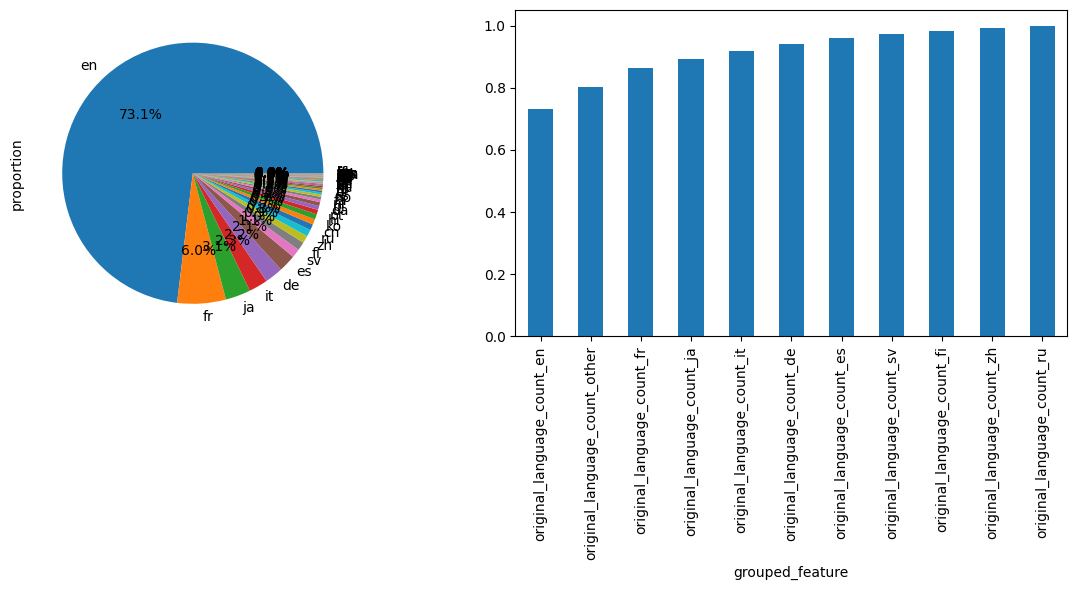

grouped_feature,original_language_count_de,original_language_count_en,original_language_count_es,original_language_count_fi,original_language_count_fr,original_language_count_it,original_language_count_ja,original_language_count_other,original_language_count_ru,original_language_count_sv,original_language_count_zh
movieId,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26738,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
movie_language_features = solve_sparse_feature(
  movie_features.reset_index(names="movieId")[["movieId", "original_language"]],
  "movieId",
  "original_language",
  concentration=0.93,
)

movie_language_features

In [10]:
features_to_normalize.extend(movie_language_features.columns)
movie_features = movie_features.merge(movie_language_features, left_index=True, right_index=True)

### Encode text as embeddings

For this part, we could go with either TF-IDF or some text embedding model. TF-IDF generated thousands of features, so sentence-transformers it is.

We are going to embed the movie title and overview.


In [11]:
# apply sentence transformer to overview
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

/home/dodo/code/recsys-movies/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [12]:
title_embeddings = model.encode(movie_features["title"].to_list(), show_progress_bar=True)
movie_features = movie_features.join(
  pd.DataFrame(title_embeddings, columns=[f"title_emb_{idx}" for idx in range(title_embeddings.shape[1])])
)
movie_features.loc[movie_features["overview"].isna(), "overview"] = ""
overview_embeddings = model.encode(movie_features["overview"].to_list(), show_progress_bar=True)
movie_features = movie_features.join(
  pd.DataFrame(overview_embeddings, columns=[f"overview_emb_{idx}" for idx in range(overview_embeddings.shape[1])])
)

Batches: 100%|██████████| 836/836 [01:47<00:00,  7.76it/s]


### Clean DataFrame and save it

Let's compare the size of the DataFrame before and after downcasting its columns.


In [13]:
movie_features = movie_features.drop(
  ["imdbId", "tmdbId", "release_date", "title", "overview", "original_language"], axis=1
)
movie_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26743 entries, 0 to 26742
Columns: 814 entries, genre_(no genres listed) to overview_emb_383
dtypes: float32(779), float64(9), int64(26)
memory usage: 86.6 MB


In [14]:
compress(movie_features)
movie_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26743 entries, 0 to 26742
Columns: 814 entries, genre_(no genres listed) to overview_emb_383
dtypes: float32(788), int16(1), int32(3), int64(1), int8(21)
memory usage: 81.5 MB


In [15]:
print(movie_features.shape)
movie_features = movie_features[~movie_features.isna().any(axis=1)]
print(movie_features.shape)

(26743, 814)
(26740, 814)


To keep a high compression rate on the file, we'll keep the features as int wherever possible and only normalize them after loading.

We'll save the names of columns that can be standardized in a file.


In [16]:
pl.Path("data/movie_features_to_normalize.txt").write_text("\n".join(features_to_normalize), encoding="utf-8")

movie_features = movie_features.set_index("id")
movie_features.to_parquet("data/movie_features.parquet")

In [17]:
movie_features

,genre_(no genres listed),genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,...,overview_emb_374,overview_emb_375,overview_emb_376,overview_emb_377,overview_emb_378,overview_emb_379,overview_emb_380,overview_emb_381,overview_emb_382,overview_emb_383
id,,,,,,,,,,,,,,,,,,,,,
862,0,0,1,1,1,1,0,0,0,1,...,0.025831,-0.101288,-0.070295,-0.001306,-0.022086,-0.007595,0.038765,0.015355,0.044632,0.022023
8844,0,0,1,0,1,0,0,0,0,1,...,0.066789,-0.037893,-0.061075,0.062395,-0.016080,0.021236,0.008645,-0.003295,-0.029277,-0.026550
15602,0,0,0,0,0,1,0,0,0,0,...,-0.038098,-0.041490,0.074784,0.088424,0.049767,0.013877,0.022851,0.056832,-0.026180,0.018336
31357,0,0,0,0,0,1,0,0,1,0,...,0.012452,-0.066199,-0.058257,0.031873,-0.007548,-0.002243,-0.000803,-0.093868,0.026814,-0.015709
11862,0,0,0,0,0,1,0,0,0,0,...,0.078969,-0.044248,-0.078170,-0.032967,0.035096,0.032306,0.004793,0.014912,0.052026,-0.053245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436,0,0,0,0,0,1,0,0,0,0,...,0.024776,0.007254,0.014782,-0.021672,-0.055362,0.023127,0.047442,0.025525,0.018140,0.003506
9274,0,0,0,0,0,1,0,0,0,0,...,0.073135,-0.107826,-0.065308,0.066255,-0.005247,0.077131,-0.009044,-0.019705,-0.094601,0.004155
285213,0,0,1,0,0,0,0,0,0,0,...,0.052659,-0.054286,-0.005510,0.012766,-0.061179,0.101851,0.072607,-0.098010,0.005809,0.011661


## Generating user features


### Which users watched which movies?


In [18]:
ratings = compress(pd.read_csv(mvls_ratings_path))
ratings.sample(5)

,userId,movieId,rating,timestamp
14641956,101142,3948,4.0,2004-02-27 03:37:41
3832401,26138,2985,3.5,2003-07-06 15:21:42
2674660,18142,1132,4.0,2008-11-20 14:56:53
18262539,126304,8861,1.0,2006-12-14 21:37:24
788412,5252,4958,4.5,2010-10-06 03:37:17


In [19]:
tags = compress(pd.read_csv(mvls_tags_path))
tags.sample(5)

,userId,movieId,tag,timestamp
82193,20845,2995,remake,2009-07-14 22:13:06
393693,122523,66097,dark fantasy,2014-03-31 17:31:28
14573,3031,91974,vampires,2015-01-10 19:08:23
151900,42890,43396,based on a true story,2013-01-16 12:38:23
444969,130827,91204,Pretty Woman twist,2011-12-10 18:12:49


In [20]:
user_movies = compress(pd.concat([ratings[["userId", "movieId"]], tags[["userId", "movieId"]]]).drop_duplicates())
user_movies.sample(5)

features_to_normalize = []

### How many movies of each genre has each user watched?


In [21]:
movie_features_genres = compress(pd.read_parquet("data/movie_features.parquet"))
genres = [c for c in movie_features_genres.columns if c.startswith("genre_")]
movie_features_genres = movie_features_genres[genres]
movie_features_genres.sample(5)

,genre_(no genres listed),genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,genre_film-noir,genre_horror,genre_imax,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_thriller,genre_war,genre_western
id,,,,,,,,,,,,,,,,,,,,
37558,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11207,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26520,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
150778,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
18437,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [22]:
user_features = compress(
  user_movies.merge(movie_features_genres, right_index=True, left_on="movieId", how="inner")
  .groupby("userId")[genres]
  .sum()
)
features_to_normalize.extend(genres)
print(user_features.index.dtypes)
user_features.sample(5)

AttributeError: 'Index' object has no attribute 'dtypes'

### Numerical movie data that can be converted into mean/std features for users


In [7]:
user_movie_genre_scores = (
  user_movies.merge(ratings, how="inner", on=["userId", "movieId"])[["userId", "movieId", "rating"]]
  .merge(movie_features_genres, right_index=True, left_on="movieId", how="inner")
  .merge(compress(pd.read_csv(mvls_links_path)), on="movieId")
  .merge(
    compress(
      pd.read_csv(tmdb_path)[
        [
          "id",
          "release_date",
          "budget",
          "runtime",
          "vote_average",
          "popularity",
        ]
      ]
    ),
    left_on="tmdbId",
    right_on="id",
    how="inner",
  )
  .set_index(["userId", "movieId"])
  .sort_index()
)
user_movie_genre_scores["release_year"] = pd.to_datetime(user_movie_genre_scores["release_date"]).dt.year
del user_movie_genre_scores["release_date"]

compress(user_movie_genre_scores).head(5)

rating  genre_(no genres listed)  genre_action  \
userId movieId                                                   
1      2           3.5                         0             0   
       112         3.5                         0             0   
       223         4.0                         0             0   
       253         4.0                         0             1   
       260         4.0                         0             0   

                genre_adventure  genre_animation  genre_children  \
userId movieId                                                     
1      2                      0                0               0   
       112                    0                0               0   
       223                    0                0               0   
       253                    1                0               0   
       260                    0                0               0   

                genre_comedy  genre_crime  genre_documentary  genre_drama  \
userId movieId                                                              
1      2                   0            0                  0            1   
       112                 1            0                  0            1   
       223                 0            0                  0            1   
       253                 0            0                  0            0   
       260                 0            0                  0            1   

                ...  genre_war  genre_western  imdbId   tmdbId     id  \
userId movieId  ...                                                     
1      2        ...          0              0  113497   8844.0   8844   
       112      ...          0              0  113326  33542.0  33542   
       223      ...          0              0  109445   2292.0   2292   
       253      ...          0              0  110148    628.0    628   
       260      ...          0              0   76759     11.0     11   

                  budget  runtime  vote_average  popularity  release_year  
userId movieId                                                             
1      2        65000000      104         7.239   13.444000          1995  
       112       7500000      104         6.817   23.479000          1995  
       223         27575       92         7.418   14.312000          1994  
       253      60000000      123         7.380   39.341999          1994  
       260      11000000      121         8.204   88.558998          1977  

[5 rows x 29 columns]

In [8]:
cols_to_avg = [
  "release_year",
  "budget",
  "runtime",
  "vote_average",
  "popularity",
]
user_features = compress(
  user_features.merge(
    user_movie_genre_scores[cols_to_avg].groupby(level=0).mean().rename(columns={c: f"avg_{c}" for c in cols_to_avg}),
    left_index=True,
    right_index=True,
  )
)
user_features = compress(
  user_features.merge(
    user_movie_genre_scores[cols_to_avg].groupby(level=0).std().rename(columns={c: f"std_{c}" for c in cols_to_avg}),
    left_index=True,
    right_index=True,
  )
)
features_to_normalize.extend([f"avg_{c}" for c in cols_to_avg])
features_to_normalize.extend([f"std_{c}" for c in cols_to_avg])
user_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138493 entries, 1 to 138493
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   genre_(no genres listed)  138493 non-null  int8   
 1   genre_action              138493 non-null  int16  
 2   genre_adventure           138493 non-null  int16  
 3   genre_animation           138493 non-null  int8   
 4   genre_children            138493 non-null  int8   
 5   genre_comedy              138493 non-null  int16  
 6   genre_crime               138493 non-null  int16  
 7   genre_documentary         138493 non-null  int8   
 8   genre_drama               138493 non-null  int16  
 9   genre_fantasy             138493 non-null  int16  
 10  genre_film-noir           138493 non-null  int8   
 11  genre_horror              138493 non-null  int16  
 12  genre_imax                138493 non-null  int8   
 13  genre_musical             138493 non-null  int8  

### User ratings per movie genre


In [9]:
# Dictionary to store results for each genre
results = {}
for genre in genres:
  # Select ratings only where the genre column is 1
  genre_ratings = user_movie_genre_scores[user_movie_genre_scores[genre] == 1]

  # Group by user_id and calculate mean rating
  avg_ratings = genre_ratings.groupby(level=0)["rating"].mean().rename(f"avg_rating_{genre[6:]}")

  # Add to results dictionary
  results[genre] = avg_ratings

  # Combine all genre results into one DataFrame
  result_df = pd.concat(results.values(), axis=1).fillna(0)  # Fill NaNs with 0 if no ratings exist

In [10]:
user_features = compress(user_features.merge(result_df, left_index=True, right_index=True))
features_to_normalize.extend(result_df.columns)

In [11]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138493 entries, 1 to 138493
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   genre_(no genres listed)       138493 non-null  int8   
 1   genre_action                   138493 non-null  int16  
 2   genre_adventure                138493 non-null  int16  
 3   genre_animation                138493 non-null  int8   
 4   genre_children                 138493 non-null  int8   
 5   genre_comedy                   138493 non-null  int16  
 6   genre_crime                    138493 non-null  int16  
 7   genre_documentary              138493 non-null  int8   
 8   genre_drama                    138493 non-null  int16  
 9   genre_fantasy                  138493 non-null  int16  
 10  genre_film-noir                138493 non-null  int8   
 11  genre_horror                   138493 non-null  int16  
 12  genre_imax                     1384

In [12]:
user_features.head()

,genre_(no genres listed),genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,...,avg_rating_film-noir,avg_rating_horror,avg_rating_imax,avg_rating_musical,avg_rating_mystery,avg_rating_romance,avg_rating_sci-fi,avg_rating_thriller,avg_rating_war,avg_rating_western
userId,,,,,,,,,,,,,,,,,,,,,
1,0,13,6,1,1,9,11,2,36,2,...,3.75,3.562500,0.0,3.75,3.916667,3.818182,3.600000,3.738095,3.625,5.000000
2,0,4,3,0,1,7,6,0,16,1,...,0.00,3.000000,0.0,0.00,3.500000,4.500000,5.000000,3.666667,5.000,3.000000
3,0,14,10,3,1,25,9,2,60,3,...,5.00,4.000000,0.0,4.00,4.444445,4.450000,3.666667,4.428571,4.000,3.666667
4,0,3,2,1,1,6,3,0,8,0,...,0.00,3.666667,0.0,0.00,3.500000,4.250000,3.200000,3.500000,0.000,0.000000
5,0,7,5,1,2,8,7,0,26,4,...,5.00,4.500000,0.0,0.00,4.333333,4.500000,4.333333,4.000000,0.000,0.000000


### User preferred movie languages

This is a tough one. There are 90 languages in the dataset, but most ratings are concentrated in movies of a few languages. This would make a feature matrix counting movies watched per language, very sparse.


In [13]:
misc_data = user_movies.merge(compress(pd.read_csv(mvls_links_path)), on="movieId").merge(
  compress(pd.read_csv(tmdb_path)[["id", "original_language"]]),
  left_on="tmdbId",
  right_on="id",
  how="inner",
)
misc_data.head()

,userId,movieId,imdbId,tmdbId,id,original_language
0,1,2,113497,8844.0,8844,en
1,1,29,112682,902.0,902,fr
2,1,32,114746,63.0,63,en
3,1,47,114369,807.0,807,en
4,1,50,114814,629.0,629,en


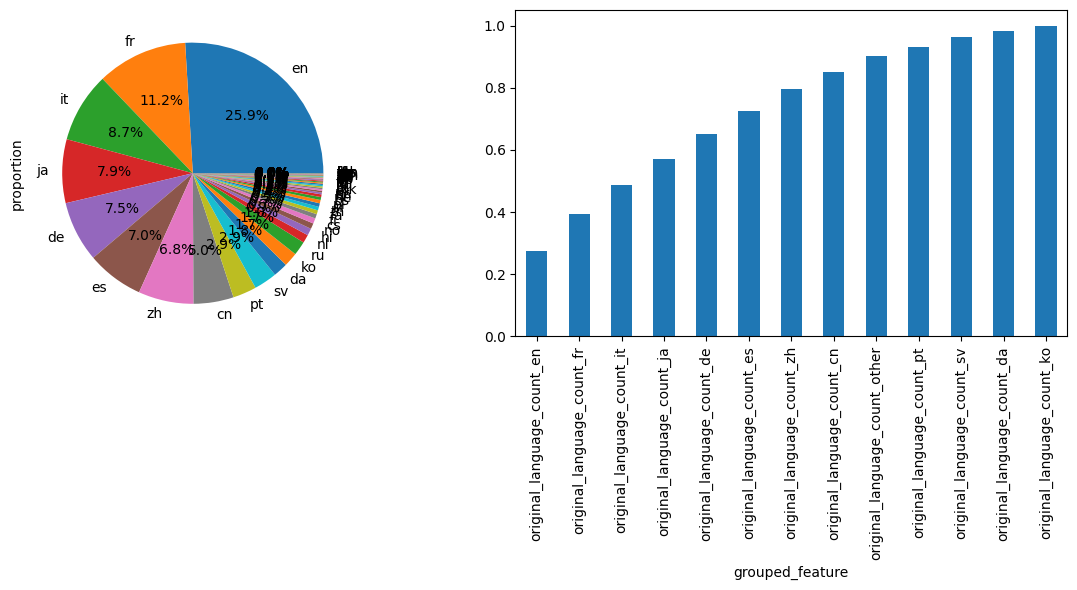

grouped_feature,original_language_count_cn,original_language_count_da,original_language_count_de,original_language_count_en,original_language_count_es,original_language_count_fr,original_language_count_it,original_language_count_ja,original_language_count_ko,original_language_count_other,original_language_count_pt,original_language_count_sv,original_language_count_zh
userId,,,,,,,,,,,,,
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138489,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
138490,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
138491,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
user_language_features = solve_sparse_feature(
  misc_data[["userId", "original_language"]].drop_duplicates(), "userId", "original_language"
)

user_language_features

In [15]:
user_features = user_features.merge(user_language_features, left_index=True, right_index=True)
features_to_normalize.extend(user_language_features.columns)
user_features.head()

,genre_(no genres listed),genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,...,original_language_count_en,original_language_count_es,original_language_count_fr,original_language_count_it,original_language_count_ja,original_language_count_ko,original_language_count_other,original_language_count_pt,original_language_count_sv,original_language_count_zh
userId,,,,,,,,,,,,,,,,,,,,,
1,0,13,6,1,1,9,11,2,36,2,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,4,3,0,1,7,6,0,16,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,14,10,3,1,25,9,2,60,3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3,2,1,1,6,3,0,8,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,7,5,1,2,8,7,0,26,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Saving user features


In [16]:
~user_features.isna().any(axis=1)

userId
1         True
2         True
3         True
4         True
5         True
          ... 
138489    True
138490    True
138491    True
138492    True
138493    True
Length: 138493, dtype: bool

In [17]:
print(user_features.shape)
user_features = user_features[~user_features.isna().any(axis=1)]
print(user_features.shape)

(138493, 63)
(138473, 63)


In [28]:
user_features.index.names = ["id"]
user_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138473 entries, 1 to 138493
Data columns (total 63 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   genre_(no genres listed)       138473 non-null  int8   
 1   genre_action                   138473 non-null  int16  
 2   genre_adventure                138473 non-null  int16  
 3   genre_animation                138473 non-null  int8   
 4   genre_children                 138473 non-null  int8   
 5   genre_comedy                   138473 non-null  int16  
 6   genre_crime                    138473 non-null  int16  
 7   genre_documentary              138473 non-null  int8   
 8   genre_drama                    138473 non-null  int16  
 9   genre_fantasy                  138473 non-null  int16  
 10  genre_film-noir                138473 non-null  int8   
 11  genre_horror                   138473 non-null  int16  
 12  genre_imax                     1384

In [29]:
pl.Path("data/user_features_to_normalize.txt").write_text("\n".join(features_to_normalize), encoding="utf-8")
user_features.to_parquet("data/user_features.parquet")

## Evaluating feature variance in dataset

Let's use PCA in both datasets to visualize the variance in the data.


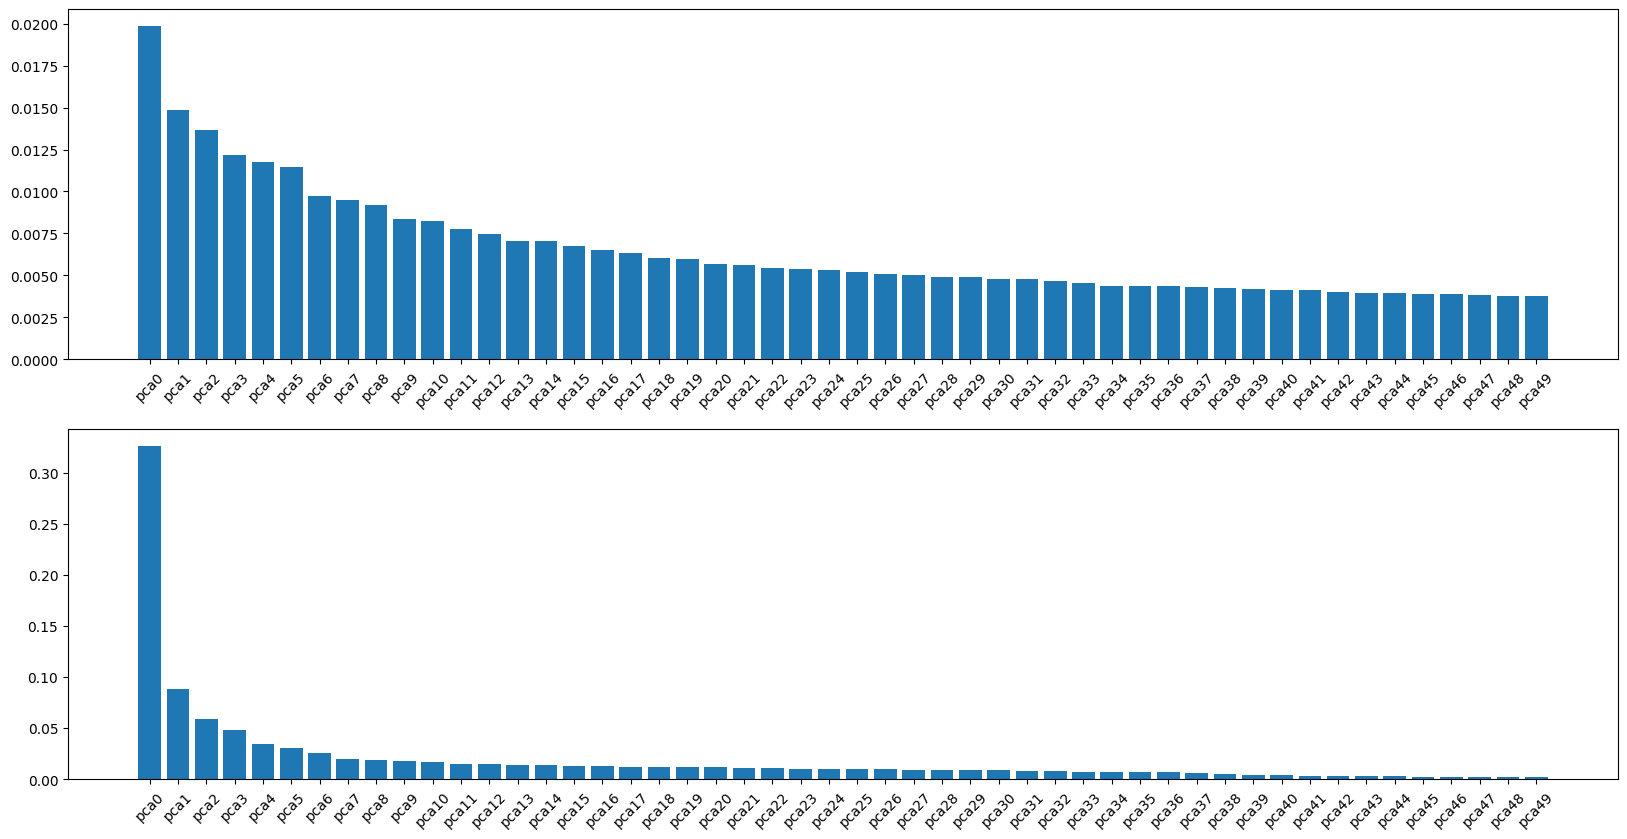

In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

movies_df = pd.read_parquet("data/movie_features.parquet")
users_df = pd.read_parquet("data/user_features.parquet")
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

pca = PCA()

pca.fit_transform(scale(movies_df))
axes[0].bar(height=pca.explained_variance_ratio_[:50], x=pca.get_feature_names_out()[:50])
axes[0].tick_params("x", rotation=45)
pca.fit_transform(scale(users_df))
axes[1].bar(height=pca.explained_variance_ratio_[:50], x=pca.get_feature_names_out()[:50])
axes[1].tick_params("x", rotation=45)

## Prepare ratings file


In [6]:
pd.read_csv(mvls_ratings_path)[["userId", "movieId", "rating"]].rename(columns={"movieId": "itemId"}).set_index([
  "userId",
  "itemId",
]).to_parquet("data/ratings.parquet")